In [1]:
!pip install opendatasets

In [2]:
import opendatasets as od

In [3]:
cd jupyter

[Errno 2] No such file or directory: 'jupyter'
/home/jupyter


In [4]:
ls

RSNA.ipynb  input/  src/  tutorials/


In [5]:
cd input 

/home/jupyter/input


In [6]:
ls

kaggle.json  rsna-intracranial-hemorrhage-detection/


In [7]:
#od.download("https://www.kaggle.com/c/rsna-intracranial-hemorrhage-detection/data")


In [8]:
pip install pydicom

Note: you may need to restart the kernel to use updated packages.


In [9]:
pip install keras


Note: you may need to restart the kernel to use updated packages.


In [10]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [11]:
pip install --upgrade keras keras-applications

Note: you may need to restart the kernel to use updated packages.


In [12]:
pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [13]:
pip install tensorflow


Note: you may need to restart the kernel to use updated packages.


In [15]:
pip install Keras-Applications 

Note: you may need to restart the kernel to use updated packages.


In [137]:
pip install -U albumentations

     |████████████████████████████████| 102 kB 7.2 MB/s            
     |████████████████████████████████| 29.2 MB 53.1 MB/s            
     |████████████████████████████████| 47.6 MB 68.0 MB/s            
     |████████████████████████████████| 178 kB 60.6 MB/s            
     |████████████████████████████████| 3.3 MB 67.2 MB/s            
Note: you may need to restart the kernel to use updated packages.


In [149]:
pip install torch

     |███████████████████████████████▉| 876.4 MB 89.6 MB/s eta 0:00:01

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



     |████████████████████████████████| 881.9 MB 9.3 kB/s             
Note: you may need to restart the kernel to use updated packages.


In [174]:
import glob, pylab, pandas as pd
import pydicom, numpy as np
from os import listdir
from os.path import isfile, join
import matplotlib.pylab as plt
import os
import tensorflow as tf
import seaborn as sns
import keras
import sys
from keras.applications.densenet import DenseNet201, DenseNet121
from keras_applications.inception_v3 import InceptionV3
from keras import layers
from keras.applications import *
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import *
from tqdm import tqdm
from torch.utils.data import Dataset
from sklearn.model_selection import ShuffleSplit
import cv2
from math import ceil, floor, log
import collections
from albumentations import (
    Compose,
    HorizontalFlip, ShiftScaleRotate,VerticalFlip,
    RandomBrightness,RandomCrop,RandomContrast
)

In [96]:
input_path = "input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/"
test_images_dir = input_path + 'stage_2_test/'
train_images_dir = input_path + 'stage_2_train/'

In [26]:
ls

RSNA.ipynb  input/  src/  tutorials/


In [31]:
train = pd.read_csv('input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_train.csv')

In [32]:
train.head(10)

,ID,Label
0,ID_12cadc6af_epidural,0
1,ID_12cadc6af_intraparenchymal,0
2,ID_12cadc6af_intraventricular,0
3,ID_12cadc6af_subarachnoid,0
4,ID_12cadc6af_subdural,0
5,ID_12cadc6af_any,0
6,ID_38fd7baa0_epidural,0
7,ID_38fd7baa0_intraparenchymal,0
8,ID_38fd7baa0_intraventricular,0
9,ID_38fd7baa0_subarachnoid,0


In [33]:
train.shape

(4516842, 2)

In [34]:
newtable = train.copy()

In [36]:
train.Label.isnull().sum()

0

In [37]:
# Images Example
train_images_dir = 'input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_train'
train_images = [f for f in listdir(train_images_dir) if isfile(join(train_images_dir, f))]
test_images_dir = 'input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_test'
test_images = [f for f in listdir(test_images_dir) if isfile(join(test_images_dir, f))]
print('5 Training images', train_images[:5])

5 Training images ['ID_e786a8062.dcm', 'ID_d89e6a64a.dcm', 'ID_e32b5aef2.dcm', 'ID_7cc736114.dcm', 'ID_f88155cda.dcm']


In [38]:
print('Total File sizes')
for f in os.listdir('input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/'):
    if 'zip' not in f:
        print(f.ljust(30) + str(round(os.path.getsize('input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/' + f) / 1000000, 2)) + 'MB')

Total File sizes
stage_2_test                  4.24MB
stage_2_sample_submission.csv 20.73MB
stage_2_train                 26.28MB
stage_2_train.csv             119.7MB


In [39]:
print('Number of train images:', len(train_images))
print('Number of test images:', len(test_images))

Number of train images: 752803
Number of test images: 121232


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Label', ylabel='count'>

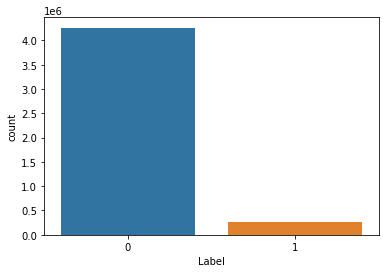

In [42]:
sns.countplot(train.Label)

In [43]:
train['Sub_type'] = train['ID'].str.split("_", n = 3, expand = True)[2]
train['PatientID'] = train['ID'].str.split("_", n = 3, expand = True)[1]

In [44]:
train.head()

,ID,Label,Sub_type,PatientID
0,ID_12cadc6af_epidural,0,epidural,12cadc6af
1,ID_12cadc6af_intraparenchymal,0,intraparenchymal,12cadc6af
2,ID_12cadc6af_intraventricular,0,intraventricular,12cadc6af
3,ID_12cadc6af_subarachnoid,0,subarachnoid,12cadc6af
4,ID_12cadc6af_subdural,0,subdural,12cadc6af


In [45]:
gbSub = train.groupby('Sub_type').sum()
gbSub

,Label
Sub_type,
any,107933
epidural,3145
intraparenchymal,36118
intraventricular,26205
subarachnoid,35675
subdural,47166


<AxesSubplot:xlabel='Label', ylabel='Sub_type'>

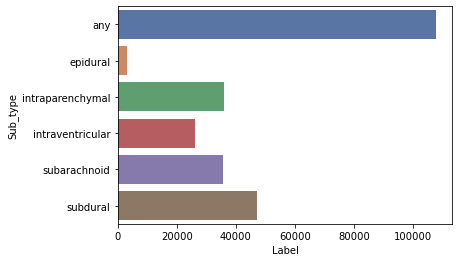

In [46]:
sns.barplot(y=gbSub.index, x=gbSub.Label, palette="deep")

In [48]:
def window_image(img, window_center,window_width, intercept, slope):

    img = (img*slope +intercept)
    img_min = window_center - window_width//2
    img_max = window_center + window_width//2
    img[img<img_min] = img_min
    img[img>img_max] = img_max
    return img 


In [49]:
def get_first_of_dicom_field_as_int(x):
    #get x[0] as in int is x is a 'pydicom.multival.MultiValue', otherwise get int(x)
    if type(x) == pydicom.multival.MultiValue:
        return int(x[0])
    else:
        return int(x)

def get_windowing(data):
    dicom_fields = [data[('0028','1050')].value, #window center
                    data[('0028','1051')].value, #window width
                    data[('0028','1052')].value, #intercept
                    data[('0028','1053')].value] #slope
    return [get_first_of_dicom_field_as_int(x) for x in dicom_fields]

In [50]:
def get_first_of_dicom_field_as_int(x):
    #get x[0] as in int is x is a 'pydicom.multival.MultiValue', otherwise get int(x)
    if type(x) == pydicom.multival.MultiValue:
        return int(x[0])
    else:
        return int(x)

def get_windowing(data):
    dicom_fields = [data[('0028','1050')].value, #window center
                    data[('0028','1051')].value, #window width
                    data[('0028','1052')].value, #intercept
                    data[('0028','1053')].value] #slope
    return [get_first_of_dicom_field_as_int(x) for x in dicom_fields]
train_images_dir

def view_images(images, title = '', aug = None):
    width = 5
    height = 2
    fig, axs = plt.subplots(height, width, figsize=(15,5))
    
    for im in range(0, height * width):
        ''''
        image = pydicom.read_file(os.path.join(train_images_dir,'ID_'+images[im]+ '.dcm')).pixel_array
        i = im // width
        j = im % width
        axs[i,j].imshow(image, cmap=plt.cm.bone) 
        axs[i,j].axis('off')'''''
        
        data = pydicom.read_file(os.path.join(train_images_dir,'ID_'+images[im]+ '.dcm'))
        image = data.pixel_array
        window_center , window_width, intercept, slope = get_windowing(data)
        image_windowed = window_image(image, window_center, window_width, intercept, slope)


        i = im // width
        j = im % width
        axs[i,j].imshow(image_windowed, cmap=plt.cm.bone) 
        axs[i,j].axis('off')
        
        
    plt.suptitle(title)
    plt.show()

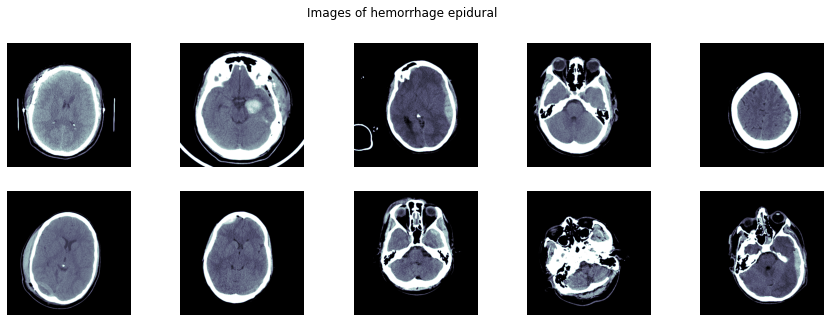

In [51]:
view_images(train[(train['Sub_type'] == 'epidural') & (train['Label'] == 1)][:10].PatientID.values, title = 'Images of hemorrhage epidural')

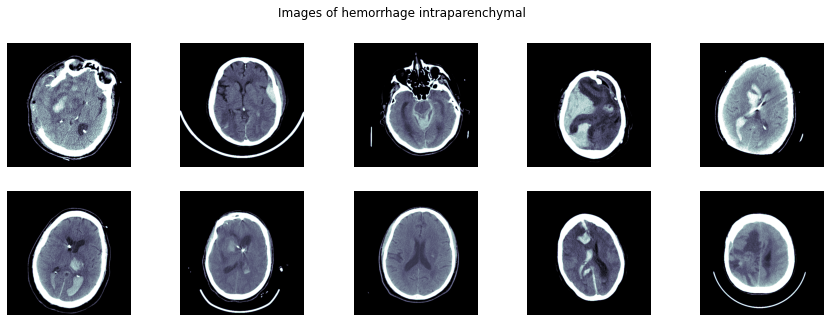

In [52]:
view_images(train[(train['Sub_type'] == 'intraparenchymal') & (train['Label'] == 1)][:20].PatientID.values, title = 'Images of hemorrhage intraparenchymal')

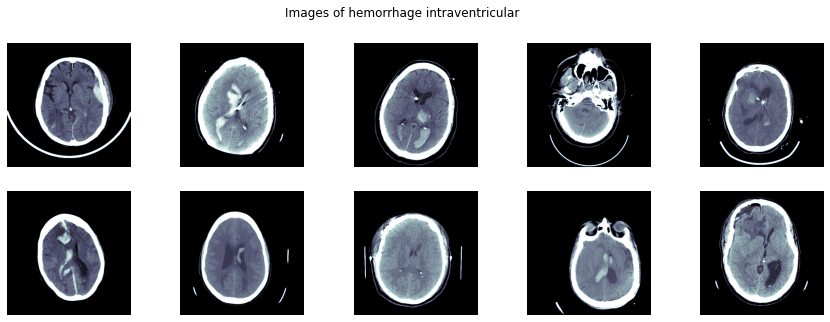

In [53]:
view_images(train[(train['Sub_type'] == 'intraventricular') & (train['Label'] == 1)][:20].PatientID.values, title = 'Images of hemorrhage intraventricular')

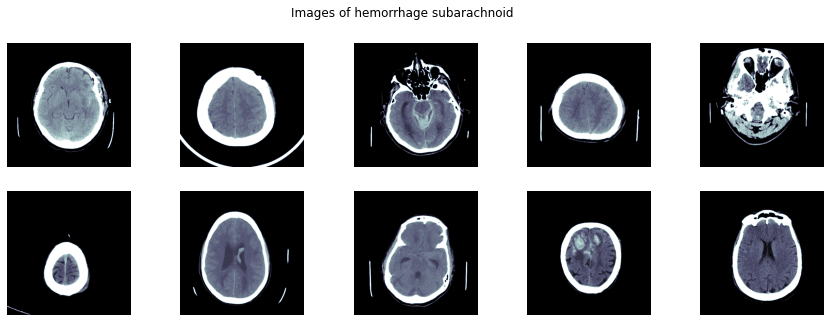

In [54]:
view_images(train[(train['Sub_type'] == 'subarachnoid') & (train['Label'] == 1)][:20].PatientID.values, title = 'Images of hemorrhage subarachnoid')

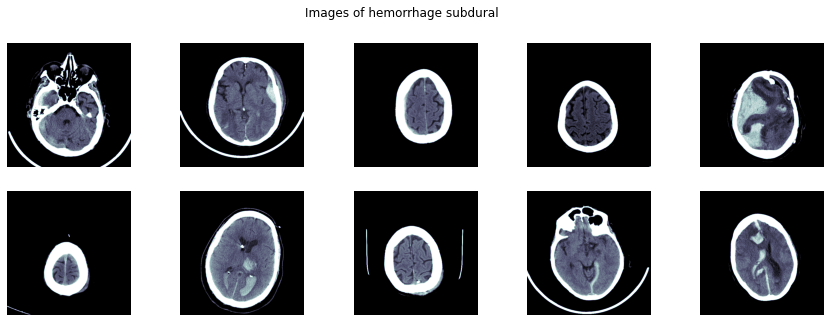

In [55]:
view_images(train[(train['Sub_type'] == 'subdural') & (train['Label'] == 1)][:20].PatientID.values, title = 'Images of hemorrhage subdural')

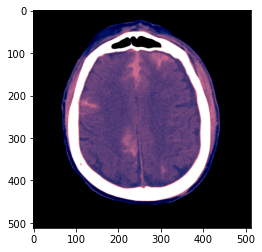

In [57]:
def correct_dcm(dcm):
    x = dcm.pixel_array + 1000
    px_mode = 4096
    x[x>=px_mode] = x[x>=px_mode] - px_mode
    dcm.PixelData = x.tobytes()
    dcm.RescaleIntercept = -1000

def window_image(dcm, window_center, window_width):
    
    if (dcm.BitsStored == 12) and (dcm.PixelRepresentation == 0) and (int(dcm.RescaleIntercept) > -100):
        correct_dcm(dcm)
    
    img = dcm.pixel_array * dcm.RescaleSlope + dcm.RescaleIntercept
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    img = np.clip(img, img_min, img_max)

    return img

def bsb_window(dcm):
    brain_img = window_image(dcm, 40, 80)
    subdural_img = window_image(dcm, 80, 200)
    soft_img = window_image(dcm, 40, 380)
    
    brain_img = (brain_img - 0) / 80
    subdural_img = (subdural_img - (-20)) / 200
    soft_img = (soft_img - (-150)) / 380
    bsb_img = np.array([brain_img, subdural_img, soft_img]).transpose(1,2,0)

    return bsb_img

# Sanity Check
# Example dicoms: ID_2669954a7, ID_5c8b5d701, ID_52c9913b1

dicom = pydicom.dcmread(train_images_dir +'/'+ 'ID_5c8b5d701' + '.dcm')
#                                     ID  Label
# 4045566          ID_5c8b5d701_epidural      0
# 4045567  ID_5c8b5d701_intraparenchymal      1
# 4045568  ID_5c8b5d701_intraventricular      0
# 4045569      ID_5c8b5d701_subarachnoid      1
# 4045570          ID_5c8b5d701_subdural      1
# 4045571               ID_5c8b5d701_any      1
plt.imshow(bsb_window(dicom), cmap=plt.cm.bone);

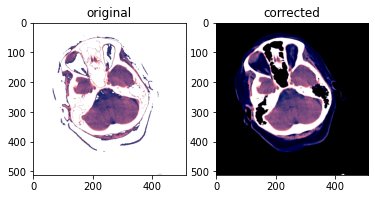

In [59]:
def window_with_correction(dcm, window_center, window_width):
    if (dcm.BitsStored == 12) and (dcm.PixelRepresentation == 0) and (int(dcm.RescaleIntercept) > -100):
        correct_dcm(dcm)
    img = dcm.pixel_array * dcm.RescaleSlope + dcm.RescaleIntercept
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    img = np.clip(img, img_min, img_max)
    return img

def window_without_correction(dcm, window_center, window_width):
    img = dcm.pixel_array * dcm.RescaleSlope + dcm.RescaleIntercept
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    img = np.clip(img, img_min, img_max)
    return img

def window_testing(img, window):
    brain_img = window(img, 40, 80)
    subdural_img = window(img, 80, 200)
    soft_img = window(img, 40, 380)
    
    brain_img = (brain_img - 0) / 80
    subdural_img = (subdural_img - (-20)) / 200
    soft_img = (soft_img - (-150)) / 380
    bsb_img = np.array([brain_img, subdural_img, soft_img]).transpose(1,2,0)

    return bsb_img

# example of a "bad data point" (i.e. (dcm.BitsStored == 12) and (dcm.PixelRepresentation == 0) and (int(dcm.RescaleIntercept) > -100) == True)
dicom = pydicom.dcmread(train_images_dir + '/'+"ID_036db39b7" + ".dcm")

fig, ax = plt.subplots(1, 2)

ax[0].imshow(window_testing(dicom, window_without_correction), cmap=plt.cm.bone);
ax[0].set_title("original")
ax[1].imshow(window_testing(dicom, window_with_correction), cmap=plt.cm.bone);
ax[1].set_title("corrected");

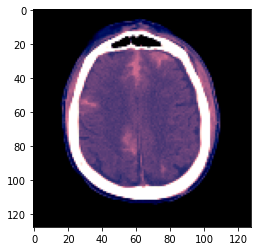

In [62]:
def _read(path, desired_size):
    """Will be used in DataGenerator"""
    
    dcm = pydicom.dcmread(path)
    
    try:
        img = bsb_window(dcm)
    except:
        img = np.zeros(desired_size)
    
    
    img = cv2.resize(img, desired_size[:2], interpolation=cv2.INTER_LINEAR)
    
    return img

# Another sanity check 
plt.imshow(
    _read(train_images_dir+ '/'+ 'ID_5c8b5d701'+'.dcm', (128, 128)), cmap=plt.cm.bone
);

In [238]:
class DataGenerator(tf.keras.utils.Sequence):

    def __init__(self, list_IDs, labels=None, batch_size=1, img_size=(512, 512, 1), 
                 img_dir=train_images_dir,augment=None, *args, **kwargs):

        self.list_IDs = list_IDs
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.img_dir = img_dir
        self.on_epoch_end()
        self.augment = augment

    def __len__(self):
        return int(ceil(len(self.indices) / self.batch_size))

    def __getitem__(self, index):
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indices]
        
        if self.labels is not None:
            X, Y = self.__data_generation(list_IDs_temp)
            return X, Y
        else:
            X = self.__data_generation(list_IDs_temp)
            return X
        
    def on_epoch_end(self):
        
        
        if self.labels is not None: # for training phase we undersample and shuffle
            # keep probability of any=0 and any=1
            keep_prob = self.labels.iloc[:, 0].map({0: 0.3, 1: 1})
            keep = (keep_prob > np.random.rand(len(keep_prob)))
            self.indices = np.arange(len(self.list_IDs))[keep]
            np.random.shuffle(self.indices)
        else:
            self.indices = np.arange(len(self.list_IDs))

    def __data_generation(self, list_IDs_temp):
        X = np.empty((self.batch_size, *self.img_size))
        
        if self.labels is not None: # training phase
            Y = np.empty((self.batch_size, 6), dtype=np.float32)
        
            for i, ID in enumerate(list_IDs_temp):
                X[i,] = _read(self.img_dir+ID+".dcm", self.img_size)
                Y[i,] = self.labels.loc[ID].values
        
            if self.augment:
                X = self.__augment(X)
            return X, Y
        
        else: # test phase
            for i, ID in enumerate(list_IDs_temp):
                X[i,] = _read(self.img_dir+ID+".dcm", self.img_size)
            
            return X
        
#     def __random_transform(self,img):
#         composition = Compose([
#             HorizontalFlip(),
#             VerticalFlip(),
#             ShiftScaleRotate(rotate_limit=45, shift_limit=0.15, scale_limit=0.15),
#             RandomBrightness(),
#             RandomContrast()
#         ])
        
#         composed = composition(image=img)
#         aug_img = composed['image']
        
#         return aug_img
        
#     def __augment(self,img_batch):
#         for i in range(img_batch.shape[0]):
#             img_batch[i, ] = self.__random_transform(img_batch[i, ])
        
#         return img_batch

In [158]:
from keras import backend as K

def weighted_log_loss(y_true, y_pred):
    """
    Can be used as the loss function in model.compile()
    ---------------------------------------------------
    """
    
    class_weights = np.array([2., 1., 1., 1., 1., 1.])
    
    eps = K.epsilon()
    
    y_pred = K.clip(y_pred, eps, 1.0-eps)

    out = -(         y_true  * K.log(      y_pred) * class_weights
            + (1.0 - y_true) * K.log(1.0 - y_pred) * class_weights)
    
    return K.mean(out, axis=-1)


def _normalized_weighted_average(arr, weights=None):
    """
    A simple Keras implementation that mimics that of 
    numpy.average(), specifically for this competition
    """
    
    if weights is not None:
        scl = K.sum(weights)
        weights = K.expand_dims(weights, axis=1)
        return K.sum(K.dot(arr, weights), axis=1) / scl
    return K.mean(arr, axis=1)


def weighted_loss(y_true, y_pred):
    """
    Will be used as the metric in model.compile()
    ---------------------------------------------
    
    Similar to the custom loss function 'weighted_log_loss()' above
    but with normalized weights, which should be very similar 
    to the official competition metric:
        https://www.kaggle.com/kambarakun/lb-probe-weights-n-of-positives-scoring
    and hence:
        sklearn.metrics.log_loss with sample weights
    """
    
    class_weights = K.variable([2., 1., 1., 1., 1., 1.])
    
    eps = K.epsilon()
    
    y_pred = K.clip(y_pred, eps, 1.0-eps)

    loss = -(        y_true  * K.log(      y_pred)
            + (1.0 - y_true) * K.log(1.0 - y_pred))
    
    loss_samples = _normalized_weighted_average(loss, class_weights)
    
    return K.mean(loss_samples)


def weighted_log_loss_metric(trues, preds):
    """
    Will be used to calculate the log loss 
    of the validation set in PredictionCheckpoint()
    ------------------------------------------
    """
    class_weights = [2., 1., 1., 1., 1., 1.]
    
    epsilon = 1e-7
    
    preds = np.clip(preds, epsilon, 1-epsilon)
    loss = trues * np.log(preds) + (1 - trues) * np.log(1 - preds)
    loss_samples = np.average(loss, axis=1, weights=class_weights)

    return - loss_samples.mean()

def f1_score(y_true, y_pred):
    """
    f1 score

    :param y_true:
    :param y_pred:
    :return:
    """
    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    return (2*precision*recall)/(precision+recall+ K.epsilon())

In [285]:
class PredictionCheckpoint(keras.callbacks.Callback):
    
    def __init__(self, test_df, valid_df, 
                 test_images_dir=test_images_dir, 
                 valid_images_dir=train_images_dir, 
                 batch_size=32, input_size=(224, 224, 3)):
        
        self.test_df = test_df
        self.valid_df = valid_df
        self.test_images_dir = test_images_dir
        self.valid_images_dir = valid_images_dir
        self.batch_size = batch_size
        self.input_size = input_size
        
    def on_train_begin(self, logs={}):
        self.test_predictions = []
        self.valid_predictions = []
        
    def on_epoch_end(self,batch, logs={}):
        self.test_predictions.append(
            self.model.predict_generator(
                DataGenerator(self.test_df.index, None, self.batch_size, self.input_size, self.test_images_dir), verbose=2)[:len(self.test_df)])
        
        # Commented out to save time
#         self.valid_predictions.append(
#             self.model.predict_generator(
#                 DataGenerator(self.valid_df.index, None, self.batch_size, self.input_size, self.valid_images_dir), verbose=2)[:len(self.valid_df)])
        
#         print("validation loss: %.4f" %
#               weighted_log_loss_metric(self.valid_df.values, 
#                                    np.average(self.valid_predictions, axis=0, 
#                                               weights=[2**i for i in range(len(self.valid_predictions))])))
        # here you could also save the predictions with np.save()


class MyDeepModel:
    
    def __init__(self, engine, input_dims, batch_size=5, num_epochs=4, learning_rate=1e-3, 
                 decay_rate=1.0, decay_steps=1, weights="imagenet", verbose=1):
        
        self.engine = engine
        self.input_dims = input_dims
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.learning_rate = learning_rate
        self.decay_rate = decay_rate
        self.decay_steps = decay_steps
        self.weights = weights
        self.verbose = verbose
        self._build()

    def _build(self):
        
        
        engine = self.engine(include_top=False, weights=self.weights, input_shape=self.input_dims,
                             backend = tf.keras.backend, layers = tf.keras.layers,
                             models = tf.keras.models, utils = tf.keras.utils)
        
        x = keras.layers.GlobalAveragePooling2D(name='avg_pool')(engine.output)
        #x = keras.layers.Dropout(0.3)(x)
#         x = keras.layers.Dense(keras.backend.int_shape(x)[1], activation="relu", name="dense_hidden_1")(x)
#         x = keras.layers.Dropout(0.1)(x)
        out = keras.layers.Dense(6, activation="sigmoid", name='dense_output')(x)

        self.model = keras.models.Model(inputs=engine.input, outputs=out)
        
        #self.model.load_weights('../input/densenet121-4-epochs/model.h5')

        self.model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Nadam(), metrics=[weighted_loss,f1_score])
        
        
    
    @tf.function
    def fit_and_predict(self, train_df, valid_df, test_df):
        
        # callbacks
        pred_history = PredictionCheckpoint(test_df, valid_df, input_size=self.input_dims)
        #checkpoint = keras.callbacks.ModelCheckpoint('model.h5', monitor='weighted_loss',verbose=1, save_best_only=True)
        scheduler = keras.callbacks.LearningRateScheduler(lambda epoch: self.learning_rate * pow(self.decay_rate, floor(epoch / self.decay_steps)))
        
        self.model.fit_generator(
            DataGenerator(
                train_df.index, 
                train_df, 
                self.batch_size, 
                self.input_dims, 
                train_images_dir,
                # augment=None
            ),
            epochs=self.num_epochs,
            verbose=self.verbose,
            use_multiprocessing=True,
            workers=4,
            callbacks=[pred_history, scheduler]
        )
        print(train_df.index)
        return pred_history
    
    def save(self, path):
        self.model.save_weights(path)
    
    def load(self, path):
        self.model.load_weights(path)

In [284]:
ls

RSNA.ipynb  Untitled.ipynb  input/  src/  tutorials/


In [286]:
def read_testset(filename="input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_sample_submission.csv"):
    df = pd.read_csv(filename)
    df["Image"] = df["ID"].str.slice(stop=12)
    df["Diagnosis"] = df["ID"].str.slice(start=13)
    
    df = df.loc[:, ["Label", "Diagnosis", "Image"]]
    df = df.set_index(['Image', 'Diagnosis']).unstack(level=-1)
    
    return df

def read_trainset(filename="input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_train.csv"):
    df = pd.read_csv(filename)
    df["Image"] = df["ID"].str.slice(stop=12)
    df["Diagnosis"] = df["ID"].str.slice(start=13)
    
    """
    print(df.shape)
    ids = df['ID']
    
    duplicates = df[ids.isin(ids[ids.duplicated()])]
    
    print(duplicates['ID'].unique().shape,duplicates['ID'].shape)
    
    print(df[df.duplicated()==False].shape)
    
    duplicates_to_remove = [
        1598538, 1598539, 1598540, 1598541, 1598542, 1598543,
        312468,  312469,  312470,  312471,  312472,  312473,
        2708700, 2708701, 2708702, 2708703, 2708704, 2708705,
        3032994, 3032995, 3032996, 3032997, 3032998, 3032999
    ]
    
    df = df.drop(index=duplicates_to_remove)
    """
    df = df.drop(index=duplicates_to_remove)
    df = df.reset_index(drop=True)
    
    df = df.loc[:, ["Label", "Diagnosis", "Image"]]
    df = df.set_index(['Image', 'Diagnosis']).unstack(level=-1)
    
    return df

    
test_df = read_testset()
df = read_trainset()

NameError: name 'duplicates_to_remove' is not defined

In [168]:
df.shape

(752803, 6)

In [169]:
test_df.shape

(121232, 6)

In [170]:
test_df.head()

Label                                                          \
Diagnosis      any epidural intraparenchymal intraventricular subarachnoid   
Image                                                                        
ID_000000e27   0.5      0.5              0.5              0.5          0.5   
ID_000009146   0.5      0.5              0.5              0.5          0.5   
ID_00007b8cb   0.5      0.5              0.5              0.5          0.5   

                       
Diagnosis    subdural  
Image                  
ID_000000e27      0.5  
ID_000009146      0.5  
ID_00007b8cb      0.5

In [171]:
df.head(15)

Label                                                          \
Diagnosis      any epidural intraparenchymal intraventricular subarachnoid   
Image                                                                        
ID_000012eaf     0        0                0                0            0   
ID_000039fa0     0        0                0                0            0   
ID_00005679d     0        0                0                0            0   
ID_00008ce3c     0        0                0                0            0   
ID_0000950d7     0        0                0                0            0   
ID_0000aee4b     0        0                0                0            0   
ID_0000ca2f6     0        0                0                0            0   
ID_0000f1657     0        0                0                0            0   
ID_000178e76     0        0                0                0            0   
ID_00019828f     0        0                0                0            0   
ID_0001dcc25     0        0                0                0            0   
ID_0001de0e8     0        0                0                0            0   
ID_0001f7f62     0        0                0                0            0   
ID_0002003a8     0        0                0                0            0   
ID_0002081b6     1        0                1                0            0   

                       
Diagnosis    subdural  
Image                  
ID_000012eaf        0  
ID_000039fa0        0  
ID_00005679d        0  
ID_00008ce3c        0  
ID_0000950d7        0  
ID_0000aee4b        0  
ID_0000ca2f6        0  
ID_0000f1657        0  
ID_000178e76        0  
ID_00019828f        0  
ID_0001dcc25        0  
ID_0001de0e8        0  
ID_0001f7f62        0  
ID_0002003a8        0  
ID_0002081b6        0

## 5. Train model and predict
##### Using train, validation and test set

##### Training for 4 epochs with Adam optimizer, with a learning rate of 0.0005 and decay rate of 0.8. The validation predictions are [exponentially weighted] averaged over all 4 epochs (same goes for the test set submission later). fit_and_predict returns validation and test predictions for all epochs.

In [255]:
pip install segmentation-models

  Attempting uninstall: efficientnet
    Found existing installation: efficientnet 1.1.1
    Uninstalling efficientnet-1.1.1:
      Successfully uninstalled efficientnet-1.1.1
Note: you may need to restart the kernel to use updated packages.


In [287]:

# import segmentation_models as sm

# sm.set_framework('tf.keras')

# sm.framework()

import efficientnet.tfkeras as efn

# train set (00%) and validation set (10%)
ss = ShuffleSplit(n_splits=10, test_size=0.1, random_state=42).split(df.index)

# lets go for the first fold only
train_idx, valid_idx = next(ss)

# obtain model
model = MyDeepModel(engine=InceptionV3,input_dims=(256, 256, 3), batch_size=32, learning_rate=5e-4,num_epochs=5, decay_rate=0.8, decay_steps=1, weights="imagenet", verbose=1)

# obtain test + validation predictions (history.test_predictions, history.valid_predictions)
# @tf.Tensor
history = model.fit_and_predict(df.iloc[train_idx], df.iloc[valid_idx], test_df)

AttributeError: in user code:

    File "/tmp/ipykernel_20888/863567377.py", line 81, in fit_and_predict  *
        self.model.fit_generator(

    AttributeError: 'Tensor' object has no attribute 'index'


In [251]:
pip --version

pip 21.3.1 from /opt/conda/lib/python3.7/site-packages/pip (python 3.7)
Note: you may need to restart the kernel to use updated packages.


NameError: name 'train_df' is not defined

In [275]:
conda create -n myenv python=3.6.4

Remove existing environment (y/[n])? ^C

CondaSystemExit: 
Operation aborted.  Exiting.


Note: you may need to restart the kernel to use updated packages.


In [276]:
pip show tensorflow

Name: tensorflow
Version: 1.14.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /opt/conda/lib/python3.7/site-packages
Requires: absl-py, astor, gast, google-pasta, grpcio, keras-applications, keras-preprocessing, numpy, protobuf, six, tensorboard, tensorflow-estimator, termcolor, wheel, wrapt
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [277]:
pip show keras

Name: Keras
Version: 2.3.0
Summary: Deep Learning for humans
Home-page: https://github.com/keras-team/keras
Author: Francois Chollet
Author-email: francois.chollet@gmail.com
License: MIT
Location: /opt/conda/lib/python3.7/site-packages
Requires: h5py, keras-applications, keras-preprocessing, numpy, pyyaml, scipy, six
Required-by: tensorflow-gpu
Note: you may need to restart the kernel to use updated packages.


In [196]:
!pip install --upgrade pip